# Autoencoder = Encoder + Decoder
[Reference](https://blog.keras.io/building-autoencoders-in-keras.html)
**Remark**: 
1. This kind of autoencoder is trained based on a particular data set. It only works well on a data set which has a similar distribution with the training data.
2. It is a lossy compression technique.
3. Autoencoder is more useful in signal denoising and dimensional reduction visualisation than in data compression.
![Autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)
Let's first build a very simple autoencoder with mnist dataset. 
(other tasks including autoencoder denoising, inpainting please refer to https://github.com/jajatikr/Video-Inpainting)

In [21]:
from keras.layers import Input, Dense
from keras.models import Model

# define the dimension of the compressed representation
compressed_dim = 36 

# mnist image shape is 28x28 = 784
img_input = Input(shape=(784,))

# first layer contains the compressed representation
compressed_rep = Dense(compressed_dim, activation='relu')(img_input)

# reconstructed image
img_rec = Dense(784, activation='sigmoid')(compressed_rep)



# build the whole autoencoder model. 
# we need to train this model only.
autoencoder= Model(img_input, img_rec)

# build the encoder model
encoder = Model(img_input,compressed_rep)

# build the decoder model
# define the compressed input
compressed_input = Input(shape=(compressed_dim,))
# build the decoder based on the last layer of autoencoder
decoder_layer = autoencoder.layers[-1](compressed_input)
decoder = Model(compressed_input,decoder_layer)

Show the model structure.

In [7]:
autoencoder.compile(optimizer='adadelta',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 36)                28260     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


Load the training and test data.

In [9]:
from keras.datasets import mnist
import numpy as np

# we don't need labels
(x_train, _), (x_test, _) = mnist.load_data()

# normalize the input values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Train the model.

In [10]:
autoencoder.fit(x_train, x_train,
               epochs=50,
               batch_size=512,
               shuffle=True,
               validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.4492 - acc: 0.7023 - val_loss: 0.2824 - val_acc: 0.7952
Epoch 2/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.2765 - acc: 0.7960 - val_loss: 0.2710 - val_acc: 0.7956
Epoch 3/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.2680 - acc: 0.7967 - val_loss: 0.2629 - val_acc: 0.7954
Epoch 4/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.2585 - acc: 0.7966 - val_loss: 0.2518 - val_acc: 0.7954
Epoch 5/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.2474 - acc: 0.7960 - val_loss: 0.2407 - val_acc: 0.7947
Epoch 6/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.2370 - acc: 0.7958 - val_loss: 0.2308 - val_acc: 0.7952
Epoch 7/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.2275 - acc: 0.7962 - val_loss: 0.2215 - val_acc: 0.79

Once the autoencoder has been trained, we can directly apply encoder and decoder on the test data.

In [11]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Data Visualization
___
Let's have a look at the performance of the encoder and the decoder.

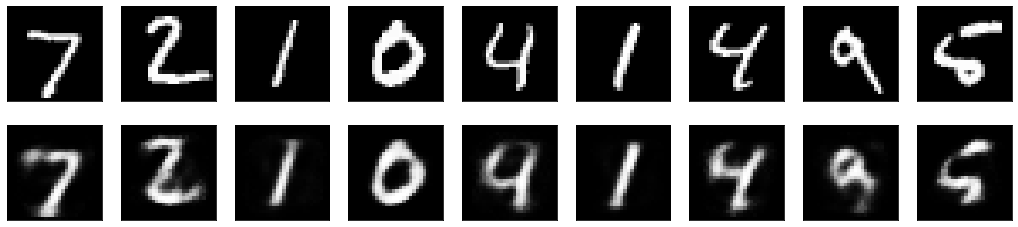

In [13]:
import matplotlib.pyplot as plt

n = 9
plt.figure(figsize=(18, 4))

for i in range(n):
    # the orignal images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # the reconstructed images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

We lost information, and the quality of the reconstructed images are not quite well.

Now, let's build an autoencoder with Convnets. Due to their strong ability to handle images, we shall achieve a much better result.

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Reload the dataset.

In [16]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [18]:
# train the new model
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.2481 - val_loss: 0.1850
Epoch 2/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.1752 - val_loss: 0.1636
Epoch 3/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.1584 - val_loss: 0.1500
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1484 - val_loss: 0.1397
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1411 - val_loss: 0.1359
Epoch 6/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1355 - val_loss: 0.1360
Epoch 7/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1314 - val_loss: 0.1279
Epoch 8/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1281 - val_loss: 0.1274
Epoch 9/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.1256 - val_loss: 0.1309
Epoch

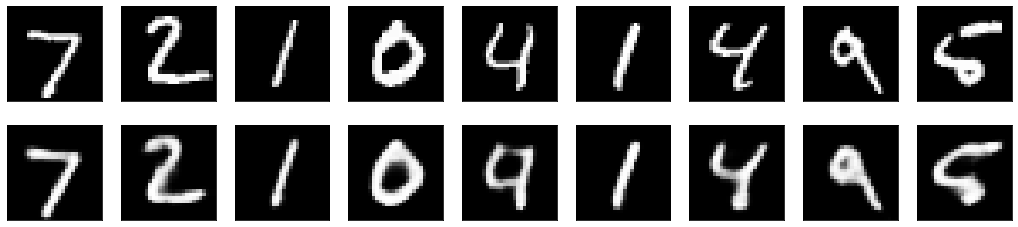

In [20]:
decoded_imgs = autoencoder.predict(x_test)

n = 9
plt.figure(figsize=(18, 4))

for i in range(n):
    # the orignal images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # the reconstructed images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

The result is much better than the one achieved by the previous model. The main reason is that by using the Convnets, we preserved much more information during the encoding process than before.
___
## Toy example of image denoising
Reload the data again.

In [22]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# add random Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# pixel value must between 0 and 1 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Show the noise corrupted images.

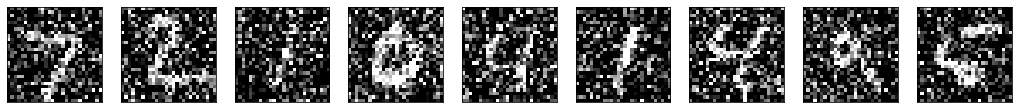

In [24]:
n = 9
plt.figure(figsize=(18, 2))

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed images, we'll use a slightly different model with more filters per layer [Reference](https://blog.keras.io/building-autoencoders-in-keras.html).

In [25]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [26]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.1769 - val_loss: 0.1235
Epoch 2/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.1195 - val_loss: 0.1144
Epoch 3/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.1118 - val_loss: 0.1077
Epoch 4/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.1079 - val_loss: 0.1070
Epoch 5/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.1057 - val_loss: 0.1049
Epoch 6/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.1042 - val_loss: 0.1024
Epoch 7/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.1028 - val_loss: 0.1003
Epoch 8/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.1021 - val_loss: 0.1021
Epoch 9/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.1012 - val_loss: 0.1

60000/60000 [==============================] - 3s 54us/step - loss: 0.0943 - val_loss: 0.0941
Epoch 78/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0943 - val_loss: 0.0943
Epoch 79/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0942 - val_loss: 0.0940
Epoch 80/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0942 - val_loss: 0.0937
Epoch 81/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0942 - val_loss: 0.0938
Epoch 82/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0942 - val_loss: 0.0937
Epoch 83/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0942 - val_loss: 0.0938
Epoch 84/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0941 - val_loss: 0.0937
Epoch 85/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0941 - val_loss: 0.0937
Epoch 86/100
60000/60000 [========================

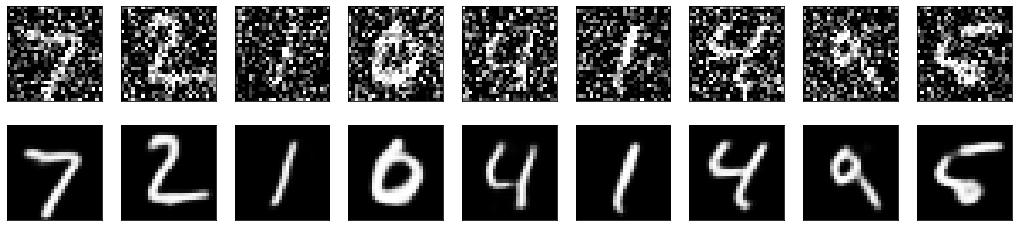

In [28]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 9
plt.figure(figsize=(18, 4))

for i in range(n):
    # the orignal images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # the reconstructed images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)